In [17]:
import numpy as np
from matplotlib import pyplot as plt
import os
import json
from omegaconf import OmegaConf
import hydra
from trainRNNbrain.analyzers.PerformanceAnalyzer import PerformanceAnalyzer
from trainRNNbrain.utils import jsonify, unjsonify
from trainRNNbrain.training.training_utils import prepare_task_arguments, get_training_mask
from trainRNNbrain.rnns.RNN_numpy import RNN_numpy
import mplcursors
from trainRNNbrain.training.training_utils import *
from pathlib import Path
from datetime import datetime, time
from zoneinfo import ZoneInfo
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.decomposition import PCA
import plotly.express as px
from PIL import Image
from tqdm.auto import tqdm
np.set_printoptions(suppress=True)
pd.set_option("display.float_format", "{:.3f}".format)
# Show all rows and columns
pd.set_option("display.max_rows", None)
pd.set_option("display.max_columns", None)
np.seterr(divide='ignore', invalid='ignore')
pd.set_option("display.expand_frame_repr", False)

import inspect
def filter_kwargs(callable_obj, params: dict):
    sig = inspect.signature(callable_obj)
    # if it accepts **kwargs, pass everything through
    if any(p.kind == p.VAR_KEYWORD for p in sig.parameters.values()):
        return params
    allowed = {name for name, p in sig.parameters.items()
               if name != 'self' and p.kind in (p.POSITIONAL_OR_KEYWORD, p.KEYWORD_ONLY)}
    return {k: v for k, v in params.items() if k in allowed}

In [18]:
# --- helpers ---
def folder_creation_dt(p: Path) -> datetime:
    """Return folder creation time as timezone-aware datetime."""
    st = p.stat()
    # Prefer true birthtime on macOS; otherwise fall back to ctime
    ts = getattr(st, "st_birthtime", st.st_ctime)
    return datetime.fromtimestamp(ts, tz=tz)

def plot_participation(participation: np.ndarray) -> None:
    fig, ax = plt.subplots()  # Create figure and axes
    ax.hist(participation, bins=50, edgecolor='black', color = 'deepskyblue')  # Plot histogram on the axes
    ax.axvline(np.quantile(participation, 0.2), linestyle='--', color = 'k')
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.set_xlabel("Participation (Std + Mean)")
    ax.set_ylabel("Number of units")
    ax.set_xlim([-0.01, max(participation)])
    mplcursors.cursor(hover=True) # Enable hover functionality
    plt.show()

def _to_probs(w: np.ndarray) -> np.ndarray:
    w = np.asarray(w, dtype=float)
    s = w.sum()
    if s <= 0:
        # define: if no participation at all, return 0 (or np.nan if you prefer)
        return None
    return w / s

def hhi_evenness(w: np.ndarray) -> float:
    p = _to_probs(w)
    if p is None:
        return 0.0
    N = p.size
    hhi = (p**2).sum()               # Simpson/Herfindahl index
    return (1.0 / hhi - 1.0) / (N - 1.0)

def gini_evenness(w: np.ndarray) -> float:
    w = np.asarray(w, dtype=float)
    s = w.sum()
    if s <= 0:
        return 0.0
    N = w.size
    ws = np.sort(w)
    # Gini via covariance/Lorenz-formula
    # sum((2i-N-1) * w_(i)) / (N * sum w)
    i = np.arange(1, N + 1)
    G = (np.sum((2 * i - N - 1) * ws)) / (N * s)
    G = abs(G)  # numerical safety
    # Normalize so max G -> 1
    Gmax = (N - 1) / N
    return 1.0 - (G / Gmax)


In [19]:
# --- inputs ---
root = Path('/Users/tolmach/Documents/GitHub/trainRNNbrain/data/trained_RNNs/CDDM_relu_Trainer_v39recovered_spatial')
tz = ZoneInfo("America/New_York")  # your timezone

# --- cutoff: today at 2 pm local time ---
# today_local = datetime.now(tz).date()
# print(today_local)
cutoff_dt_low = datetime.combine(datetime.strptime("2025-10-13", "%Y-%m-%d").date(), time(20, 0, 0), tzinfo=tz)
cutoff_dt_high = datetime.combine(datetime.strptime("2025-10-30", "%Y-%m-%d").date(), time(0, 0, 0), tzinfo=tz)

subfolders = [p for p in root.iterdir() if p.is_dir()]

# Filter by creation time after 2pm today
filtered = [(p, folder_creation_dt(p)) for p in subfolders if (folder_creation_dt(p) >= cutoff_dt_low) and (folder_creation_dt(p) <= cutoff_dt_high)]

# Sort by creation time (optional)
filtered.sort(key=lambda t: t[1])
rows = []
print(f"Found {len(filtered)} subfolders created on/after {cutoff_dt_low} and before {cutoff_dt_high}:")
task = None
for p, cdt in tqdm(filtered):
    # if True and ("lmbdR=0.1" in p.name) and ("lmbdHVar=0.05" in p.name) and not ("lmbdIZ=0;" in p.name):
    # print(f"\n{subfolder:=^80}")
    data_folder = p.name
    # print(f"subfolder: {data_folder}  |  created: {cdt.isoformat()} \n")
    score = data_folder.split("/")[-1].split("_")[0]
    cfg = OmegaConf.load(os.path.join(root, data_folder, f'{score}_config.yaml'))
    if not OmegaConf.has_resolver("eval"):
        OmegaConf.register_new_resolver("eval", eval)
    
    if (task is None):
        taskname = cfg.task.taskname
        tag = f"relu_constrained=constrained"
        # defining the task
        task_conf = prepare_task_arguments(cfg_task=cfg.task, dt=cfg.model.dt)
        task = hydra.utils.instantiate(task_conf)
        mask = get_training_mask(cfg_task=cfg.task, dt=cfg.model.dt)
    try:
        net_params_file = f"{score}_LatestParams_CDDM.json"
    except:
        net_params_file = f"{score}_params_CDDM.json"
    with open(os.path.join(root, data_folder, net_params_file), 'r') as f:
        net_params = unjsonify(json.load(f))

    net_params_filtered = filter_kwargs(RNN_numpy, net_params)
    RNN = RNN_numpy(**net_params_filtered)
    N = np.array(net_params["W_rec"]).shape[0]
    analyzer = PerformanceAnalyzer(RNN)
    score_function = lambda x, y: 1 - (np.mean((x - y) ** 2) / np.mean(y ** 2))
    input_batch_valid, target_batch_valid, conditions_valid = task.get_batch()
    score = analyzer.get_validation_score(score_function,
                                          input_batch_valid, target_batch_valid,
                                          mask,
                                          sigma_rec=0, sigma_inp=0)
    score = np.round(score, 7)
    folder_score = float(data_folder.split("_")[0])

    task.coherences = np.array([-0.5, -0.2, -0.1, -0.05, 0, 0.05, 0.1, 0.2, 0.5])
    input_batch, target_batch, conditions = task.get_batch()
    trajectories, outputs = analyzer.get_trajectories(input_batch) # get sorted trajectories
    participation = np.std(trajectories, axis = (1, 2)) + np.quantile(np.abs(trajectories), axis = (1, 2), q=0.9)
    time_variability = np.mean(np.std(trajectories, axis=1))
    mean_participation = np.quantile(participation, 0.5)
    
    g = gini_evenness(participation)
    hhi = hhi_evenness(participation)
    
    row = {}
    row = {key: cfg.trainer[key] for key in cfg.trainer.keys()}
    eps = 1e-6
    a = np.max(trajectories, axis=(1, 2))
    N_eff = np.sum(a > eps)

    row["meanA"] = np.mean(a[np.where(a > eps)[0]])
    wout = np.asarray(net_params["W_out"])
    winp = np.asarray(net_params["W_inp"])
    row["mWout"] = np.mean(wout[np.where(wout > eps)[0]])
    row["mWinp"] = np.mean(winp[np.where(wout > eps)[0]])
    W  = np.asarray(net_params["W_rec"])
    dm = np.sign(np.sum(W, axis=0))
    wrecE = np.abs(W[:, dm > 0])
    wrecI = np.abs(W[:, dm < 0])
    row["mWrec_exc"] = np.mean(wrecE[np.where(wrecE > eps)[0]])  # mean over all exc columns
    row["mWrec_inh"] = np.mean(wrecI[np.where(wrecI > eps)[0]])  # mean over all inh columns
    row["Gini_index"] = g
    row["tVar"] = time_variability
    row["N"] = N_eff
    row["folder"] = data_folder
    rows.append(row)
    # plot_participation(participation)
consolidated_data = pd.DataFrame(rows).sort_values(by="Gini_index", ascending=False)


Found 197 subfolders created on/after 2025-10-13 20:00:00-04:00 and before 2025-10-30 00:00:00-04:00:


  0%|          | 0/197 [00:00<?, ?it/s]

In [4]:
print(consolidated_data.columns)

Index(['max_iter', 'tol', 'lr', 'weight_decay', 'orth_input_only',
       'lambda_orth', 'lambda_iwm', 'lambda_met', 'lambda_rwm', 'lambda_ow',
       'lambda_rws', 'lambda_sm', 'lambda_tv', 'lambda_si', 'lambda_hi',
       'lambda_htvar', 'lambda_hlvar', 'lambda_cl', 'p', 'same_batch',
       'dropout', 'drop_rate', 'inequality_method', 'meanA', 'mWout', 'mWinp',
       'mWrec_exc', 'mWrec_inh', 'Gini_index', 'tVar', 'N', 'folder'],
      dtype='object')


In [20]:
consolidated_data["score"] = pd.to_numeric([float(f.split("_")[0]) for f in consolidated_data["folder"]], errors="coerce")

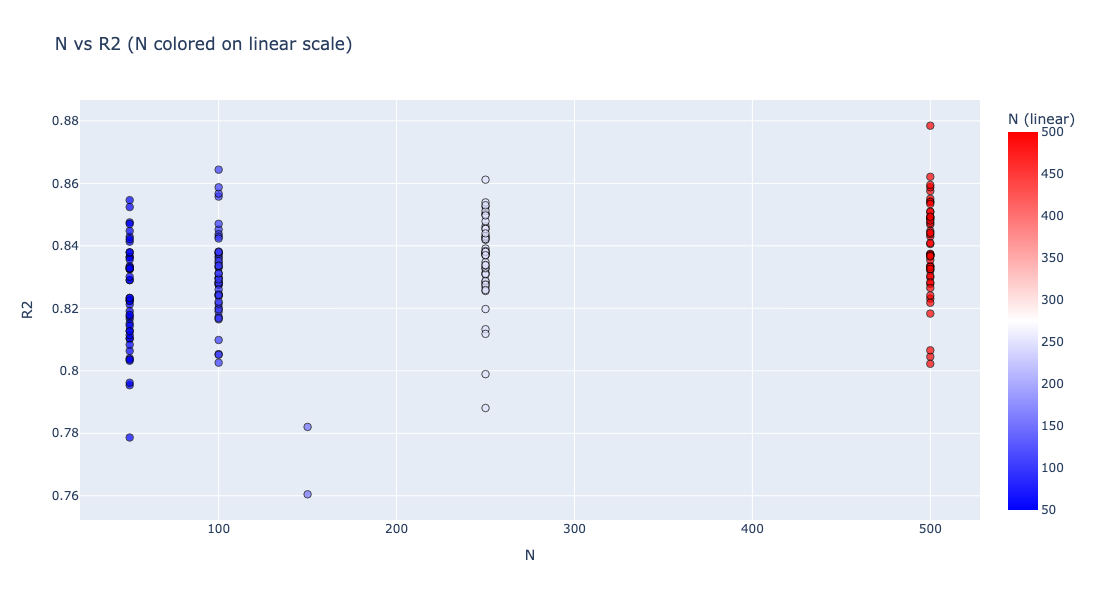

In [32]:
import numpy as np, pandas as pd, plotly.express as px

df = pd.DataFrame(consolidated_data)
df["R2"] = df["folder"].str.extract(r"^([0-9\.]+)").astype(float)
df = df.drop(columns=["folder"])
df = df[df["R2"] > 0.75]

column = "N"          # the column to color by
scale  = "linear"     # or "log"

# --- ensure numeric column (encode non-numeric) ---
if not np.issubdtype(df[column].dtype, np.number):
    df[column + "_string"] = df[column]
    df[column] = pd.Categorical(df[column]).codes

df[column] = pd.to_numeric(df[column], errors="coerce")
df = df.dropna(subset=[column])

# --- prepare color data (linear vs log) ---
if scale == "log":
    df = df[df[column] > 0]                          # log requires positive
    color_col = f"{column}_log10"
    df[color_col] = np.log10(df[column].to_numpy())

    # nice log ticks in original space (decades)
    vmin, vmax = df[column].min(), df[column].max()
    decades = np.arange(np.floor(np.log10(vmin)), np.ceil(np.log10(vmax)) + 1)
    ticks = np.power(10.0, decades)
    tickvals = np.log10(ticks)                       # where they land in log space
    ticktext = [f"{t:g}" for t in ticks]
    cbar_title = f"{column} (log10 scale)"
else:
    color_col = column
    vmin, vmax = float(df[color_col].min()), float(df[color_col].max())
    tickvals, ticktext = None, None
    cbar_title = f"{column} (linear)"

# --- midpoint & range in the SAME space as color_col ---
cmin, cmax = float(df[color_col].min()), float(df[color_col].max())
cmid = 0.5 * (cmin + cmax)

bwr_scale = [(0, "blue"), (0.5, "white"), (1, "red")]  # keep your palette

x_label, y_label = "N", "R2"
fig = px.scatter(
    df,
    x=x_label, y=y_label,
    color=color_col,
    color_continuous_scale=bwr_scale,
    color_continuous_midpoint=cmid,
    range_color=(cmin, cmax),
    hover_data=df.columns,
    title=f"{x_label} vs {y_label} ({column} colored on {scale} scale)"
)

x = 1.5
fig.update_layout(
    autosize=False, width=500 * x, height=400 * x,
    coloraxis_colorbar=dict(title=cbar_title, tickvals=tickvals, ticktext=ticktext)
)
fig.update_traces(marker=dict(opacity=0.7, size=5 * x, line=dict(width=1, color="black")))
fig.write_image(f"statistics_{x_label}_vs_{y_label}_SE.svg")
fig.show()


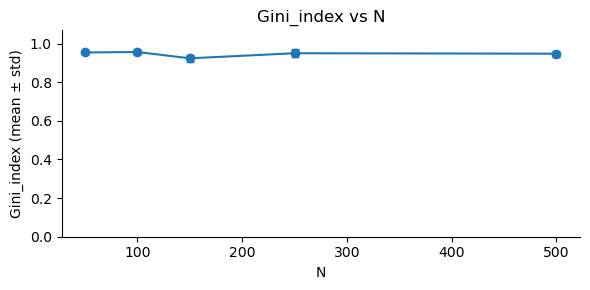

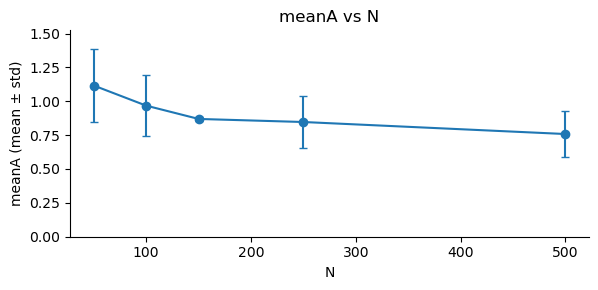

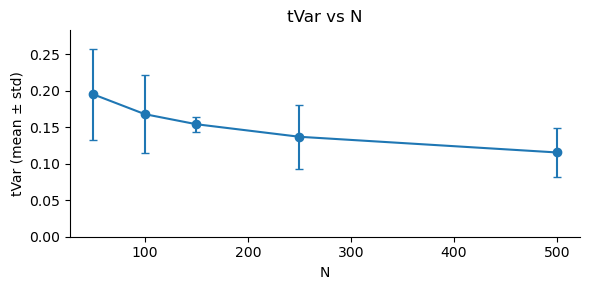

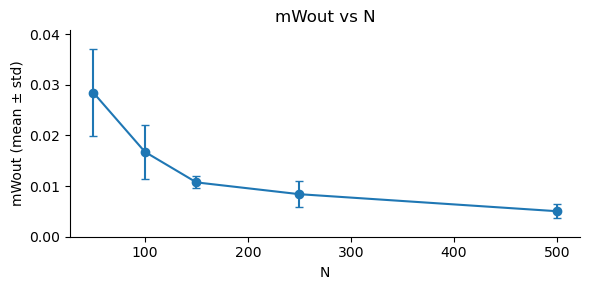

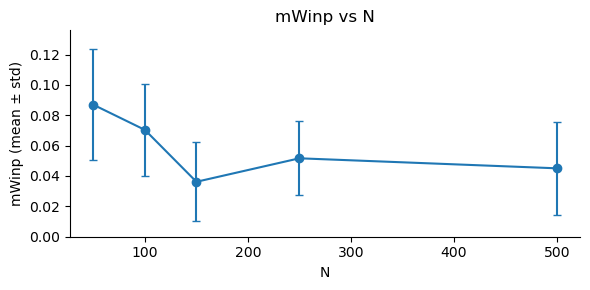

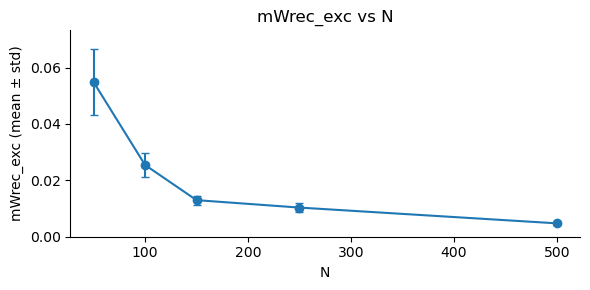

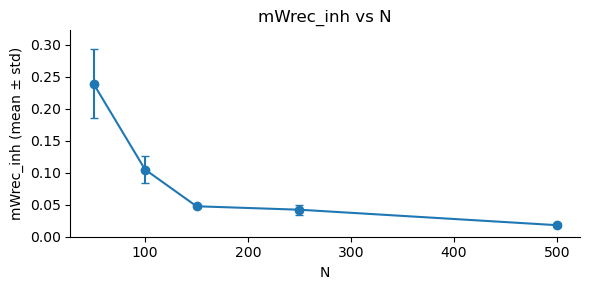

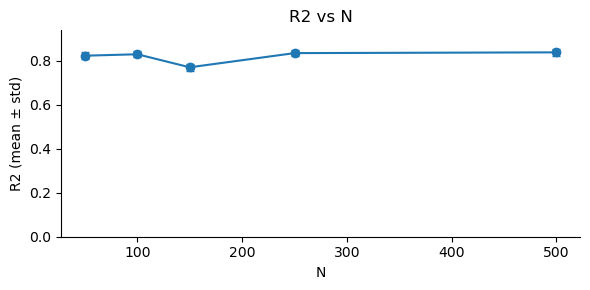

In [31]:
for col in ['Gini_index', 'meanA', 'tVar', 'mWout', 'mWinp', 'mWrec_exc', 'mWrec_inh', 'R2']:
    g = df.groupby('N')[col].agg(['mean','var','count']).reset_index().sort_values('N')
    x   = g['N'].to_numpy()
    y   = g['mean'].to_numpy()
    err = np.sqrt(g['var'].to_numpy())               # std
    # if ~np.isnan(err).any():
        # err = err / np.sqrt(g['count'].to_numpy())     # <- use this for SEM instead
        
    fig, ax = plt.subplots(figsize=(6, 3))
    ax.errorbar(x, y, yerr=err, fmt='-o', capsize=3)
    ax.set_xlabel('N')
    ax.set_ylabel(f'{col} (mean ± std)')
    ax.set_title(f'{col} vs N')
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.set_ylim([0, np.nanmax(y + err)*1.1])
    fig.tight_layout()
    plt.savefig(f"{col}_SE_networks.svg", bbox_inches='tight', dpi=300) 
    plt.show()


In [ ]:
col = 'meanA'
g = df.groupby('N')[col].agg(['mean','var','count']).reset_index().sort_values('N')
x   = g['N'].to_numpy()
y   = g['mean'].to_numpy()
err = np.sqrt(g['var'].to_numpy())               # std
# if ~np.isnan(err).any():
    # err = err / np.sqrt(g['count'].to_numpy())     # <- use this for SEM instead

fig, ax = plt.subplots(figsize=(6, 3))
ax.errorbar(x, y, yerr=err, fmt='-o', capsize=3)
z = 0.7 * np.log(100) / np.log(x)
ax.plot(x, z)
ax.set_xlabel('N')
ax.set_ylabel(f'{col} (mean ± std)')
ax.set_title(f'{col} vs N')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_ylim([0, np.nanmax(y + err)*1.1])
fig.tight_layout()
plt.show()


In [ ]:
col = 'mWout'
g = df.groupby('N')[col].agg(['mean','var','count']).reset_index().sort_values('N')
x   = g['N'].to_numpy()
y   = g['mean'].to_numpy()
err = np.sqrt(g['var'].to_numpy())               # std
# if ~np.isnan(err).any():
    # err = err / np.sqrt(g['count'].to_numpy())     # <- use this for SEM instead
fig, ax = plt.subplots(figsize=(6, 3))
ax.errorbar(x, y, yerr=err, fmt='-o', capsize=3)
# ax.errorbar(x, y*z, color='r')
ax.set_xlabel('N')
ax.set_ylabel(f'{col} (mean ± std)')
ax.set_title(f'{col} vs N')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_ylim([0, np.max(y + err)*1.1])
fig.tight_layout()
plt.show()